<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson05_VAE_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 5. Simple VAE excerise
1. Re-use lesson 3's code
2. Try to implement your simple VAE using the MNIST dataset
3. Explore some simple ideas about the generative model
4. Compare the results with Pytorch


In [22]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transform

In [23]:
tt = transform.Compose([transform.ToTensor()])

train_data = MNIST(root='./data', train=True, transform=tt, download=True)
test_data = MNIST(root='./data', train=False, transform=tt)

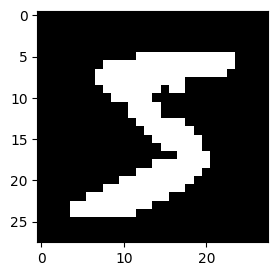

In [28]:
def transform_from_torch_to_numpy(torch_data):
    features_np = torch_data.data.numpy()
    labels_np = torch_data.targets.numpy()

    features_np = np.resize(features_np, (features_np.shape[0], features_np.shape[1] * features_np.shape[2]))

    # Simplify the exercise
    features_np[features_np != 0] = 1

    labels = np.zeros((labels_np.shape[0], 10))
    for i in range(10):
        labels[labels_np==i, i] = 1.

    return features_np, labels

train_features, train_labels = transform_from_torch_to_numpy(train_data)
test_features, test_labels = transform_from_torch_to_numpy(test_data)

import matplotlib.pyplot as plt
figure = plt.figure(figsize=(3, 3))
x = np.resize(train_features[0], (28, 28))
plt.imshow(x, cmap='gray')
plt.show()

In [29]:
def shuffle_dataset(n, batch_size):
    idices= np.array(range(n))
    np.random.shuffle(idices)
    batch_sample_size = int((n - n % batch_size) / batch_size)
    m = int(batch_size * batch_sample_size)
    a = idices[0:m].reshape((batch_size, batch_sample_size))
    b = idices[m:].reshape((1, n % batch_size))
    return a

def get_precision(predict, y):
    a = np.argmax(predict, axis=1)
    b = np.argmax(y, axis=1)
    print(np.sum(a == b) / y.shape[0])

In [30]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        m = dL_by_dZ.shape[0]
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        #dZ/dW = X.T (n+1, m) .dot dL/dZ = (m, out)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) / m #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H

    def update_weights(self, learning_rate):
        return

class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        #self.Y_hat = self.process_function(Z)
        self.Y_hat = Z
        #print(self.Y_hat[0])
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        #print(self.loss)
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

class Operator_Packager:
    def __init__(self, operator_list):
        self.operator_list = operator_list

    def forward(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].forward(Z)
        return Z

    def backward(self, E):
        d = E
        size = len(self.operator_list)
        for i in range(size):
            index = size - 1 - i
            d = self.operator_list[index].backward(d)
        return d

    def predict(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].predict(Z)
        #Y_hat = softmax(Z)
        Y_hat = Z
        return Y_hat

    def update_weights(self, learning_rate):
        size = len(self.operator_list)
        for i in range(size):
            self.operator_list[i].update_weights(learning_rate)


In [36]:
class VAE:
    def __init__(self, size_of_features, size_of_bottle):
        self.model = Operator_Packager([
            Linear(size_of_features, 100),
            Sigmoid_Active_Function(),
            Linear(100, 50),
            Sigmoid_Active_Function(),
            Linear(50, size_of_bottle),
            Linear(size_of_bottle, 50),
            Sigmoid_Active_Function(),
            Linear(50, 100),
            Sigmoid_Active_Function(),
            Linear(100, size_of_features),
            Sigmoid_Active_Function()
        ])
        self.bottle_layer = 3

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        Y = self.model.predict(X)
        return Y

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

    def encode(self, X):
        Z = X
        for i in range(self.bottle_layer):
            Z = self.model.operator_list[i].predict(Z)
        return Z

    def decode(self, Z):
        X = Z
        for i in range(self.bottle_layer, len(self.model.operator_list)):
            X = self.model.operator_list[i].predict(X)
        return X

Epoch 1
-------------------------------
t: 1  loss : 157567.74645716336


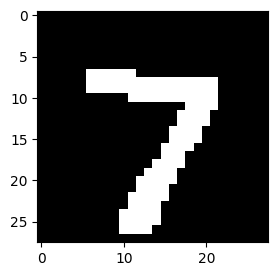

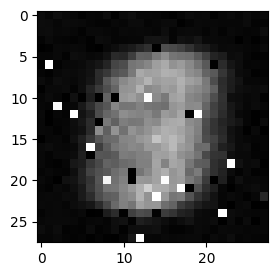

t: 2  loss : 149230.28172526212
t: 3  loss : 142034.77054049235
t: 4  loss : 144740.97437079262
t: 5  loss : 148092.3498690574
t: 6  loss : 129717.76747630427
t: 7  loss : 126047.48292086869
t: 8  loss : 119795.49846369486
t: 9  loss : 114893.87339863661
t: 10  loss : 135209.34082403532
Epoch 11
-------------------------------
t: 11  loss : 109440.73090484073
t: 12  loss : 116658.41099729232
t: 13  loss : 103689.8491787118
t: 14  loss : 98252.01488145464
t: 15  loss : 100647.15626872984
t: 16  loss : 101907.57628987546
t: 17  loss : 91781.97074889962
t: 18  loss : 98094.6414585845
t: 19  loss : 89891.40500176168
t: 20  loss : 100640.46140687288
Epoch 21
-------------------------------
t: 21  loss : 89565.30992423384


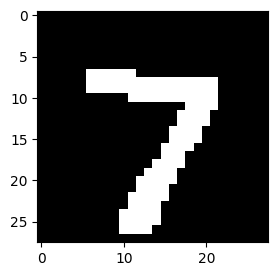

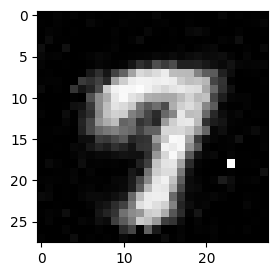

t: 22  loss : 81870.56228977839
t: 23  loss : 90153.75179332268
t: 24  loss : 95864.35666385073
t: 25  loss : 84717.8722695579
t: 26  loss : 90087.38679505438
t: 27  loss : 79112.51537958745
t: 28  loss : 75032.18691965609
t: 29  loss : 76737.36709530377
t: 30  loss : 88838.1005606214
Epoch 31
-------------------------------
t: 31  loss : 75704.06207030678
t: 32  loss : 89118.95121622011
t: 33  loss : 73996.83027889291
t: 34  loss : 77138.89310344051
t: 35  loss : 83997.95456662978
t: 36  loss : 73239.85551404044
t: 37  loss : 78312.60208396488
t: 38  loss : 70968.55651140476
t: 39  loss : 80956.58752183568
t: 40  loss : 71978.58276518177
Epoch 41
-------------------------------
t: 41  loss : 67446.9195330292


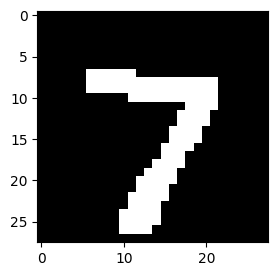

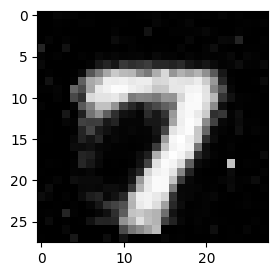

t: 42  loss : 72716.59297197209
t: 43  loss : 72084.95777688667
t: 44  loss : 77790.57819094622
t: 45  loss : 72898.59204158164
t: 46  loss : 74101.35820607828
t: 47  loss : 79454.3047344061
t: 48  loss : 68432.35601404152
t: 49  loss : 69254.33819284002
t: 50  loss : 64098.00747686683
Epoch 51
-------------------------------
t: 51  loss : 78286.90912527493
t: 52  loss : 63263.287750893556
t: 53  loss : 80369.22934215465
t: 54  loss : 64895.71675455535
t: 55  loss : 59122.42473397889
t: 56  loss : 76956.21919826105
t: 57  loss : 67206.21704924798
t: 58  loss : 58731.68747417592
t: 59  loss : 68817.05668512727
t: 60  loss : 64352.74481680156
Epoch 61
-------------------------------
t: 61  loss : 56625.80202532241


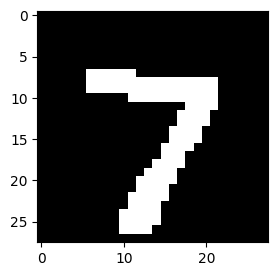

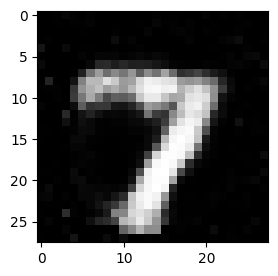

t: 62  loss : 60847.88946511217
t: 63  loss : 59107.283457708356
t: 64  loss : 71206.7954808131
t: 65  loss : 63681.92409035413
t: 66  loss : 55124.33543316662
t: 67  loss : 64027.010627689844
t: 68  loss : 68588.4657799373
t: 69  loss : 56449.304904846475
t: 70  loss : 53654.876086705444
Epoch 71
-------------------------------
t: 71  loss : 56614.31249196247
t: 72  loss : 56646.39466583257
t: 73  loss : 52991.338685035684
t: 74  loss : 59052.05802098502
t: 75  loss : 63496.88608101557
t: 76  loss : 53975.28837225035
t: 77  loss : 52088.17907364208
t: 78  loss : 50405.745335321415
t: 79  loss : 63183.78161535828
t: 80  loss : 56123.06687686666
Epoch 81
-------------------------------
t: 81  loss : 55751.66495556364


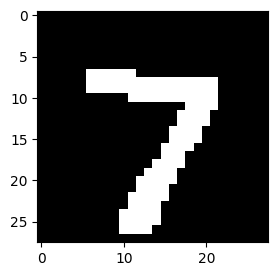

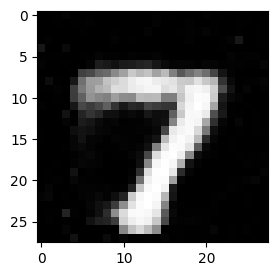

t: 82  loss : 66300.73881046292
t: 83  loss : 64966.302760641105
t: 84  loss : 51039.73256327183
t: 85  loss : 65042.50735092789
t: 86  loss : 51737.24909055917
t: 87  loss : 52255.39010417425
t: 88  loss : 58039.64399593652
t: 89  loss : 71083.18100372374
t: 90  loss : 61453.230854848596
Epoch 91
-------------------------------
t: 91  loss : 59447.58341839216
t: 92  loss : 49174.256762439945
t: 93  loss : 65369.06600133813
t: 94  loss : 47261.18647826225
t: 95  loss : 52168.374122160814
t: 96  loss : 59695.89296552512
t: 97  loss : 56675.4923583684
t: 98  loss : 47427.30367205164
t: 99  loss : 49224.306548195374
t: 100  loss : 52791.45271974588
Epoch 101
-------------------------------
t: 101  loss : 61880.267399638695


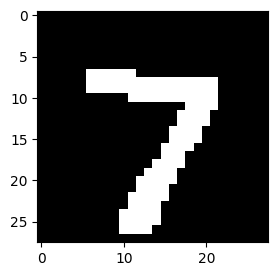

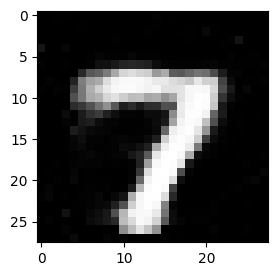

t: 102  loss : 74686.19710333858
t: 103  loss : 63287.18694855039
t: 104  loss : 58809.75472975488
t: 105  loss : 61647.75555340698
t: 106  loss : 58568.27340764897
t: 107  loss : 64335.57855889079
t: 108  loss : 45251.65675940273
t: 109  loss : 54975.37093662145
t: 110  loss : 52208.12496348059
Epoch 111
-------------------------------
t: 111  loss : 51379.894681791084
t: 112  loss : 55123.398082161664
t: 113  loss : 60041.11972424529
t: 114  loss : 59252.16685487113
t: 115  loss : 47475.88000701767
t: 116  loss : 47261.05116518247
t: 117  loss : 60152.34253251041
t: 118  loss : 44667.95287612527
t: 119  loss : 51894.741788271815
t: 120  loss : 44156.221497062485
Epoch 121
-------------------------------
t: 121  loss : 56618.79813582054


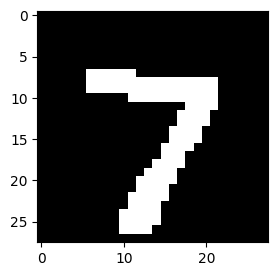

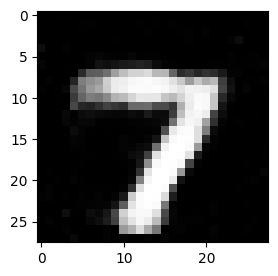

t: 122  loss : 49294.27539132007
t: 123  loss : 50362.928637309626
t: 124  loss : 60371.34908897235
t: 125  loss : 51132.914692396866
t: 126  loss : 61721.24524623598
t: 127  loss : 55710.600849189614
t: 128  loss : 46984.743494679205
t: 129  loss : 45201.73637778767
t: 130  loss : 45750.16147102673
Epoch 131
-------------------------------
t: 131  loss : 44956.7170329807
t: 132  loss : 65165.37525105131
t: 133  loss : 41292.63753571763
t: 134  loss : 47176.17674604148
t: 135  loss : 49419.20310025764
t: 136  loss : 57672.22331654667
t: 137  loss : 45771.28912844879
t: 138  loss : 59187.5256709155
t: 139  loss : 60600.80618149424
t: 140  loss : 52847.25591785588
Epoch 141
-------------------------------
t: 141  loss : 51425.763901154


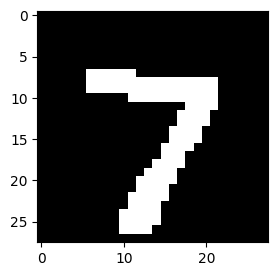

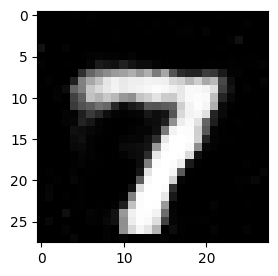

t: 142  loss : 58046.305822176255
t: 143  loss : 42725.61270794471
t: 144  loss : 52329.95871265108
t: 145  loss : 41364.77004061367
t: 146  loss : 48941.58947217506
t: 147  loss : 51796.81721989945
t: 148  loss : 60756.48013620437
t: 149  loss : 44399.40777744502
t: 150  loss : 44292.63977297906
Epoch 151
-------------------------------
t: 151  loss : 42285.62309291556
t: 152  loss : 41696.8390669108
t: 153  loss : 44969.65592506993
t: 154  loss : 48112.4374927674
t: 155  loss : 43446.615503872
t: 156  loss : 57909.03338583776
t: 157  loss : 52489.204579380275
t: 158  loss : 49051.71335409101
t: 159  loss : 49188.270247221626
t: 160  loss : 49080.623023254666
Epoch 161
-------------------------------
t: 161  loss : 40457.607399990266


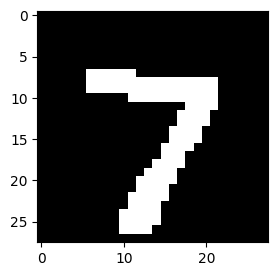

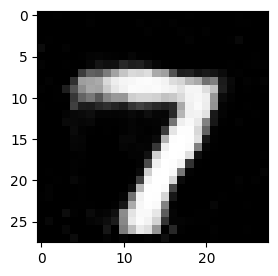

t: 162  loss : 46467.77354947312
t: 163  loss : 55268.49325068708
t: 164  loss : 61236.85140730757
t: 165  loss : 53380.59088519065
t: 166  loss : 41995.676439829345
t: 167  loss : 52621.65970973176
t: 168  loss : 47078.67800866165
t: 169  loss : 55209.68658339608
t: 170  loss : 49848.61063638596
Epoch 171
-------------------------------
t: 171  loss : 56091.27341427804
t: 172  loss : 50733.74373005405
t: 173  loss : 42178.24641534473
t: 174  loss : 49237.249678759916
t: 175  loss : 50826.40771116038
t: 176  loss : 61209.20762660054
t: 177  loss : 48867.58019121325
t: 178  loss : 56552.2031477725
t: 179  loss : 39390.22182729535
t: 180  loss : 53539.92941823294
Epoch 181
-------------------------------
t: 181  loss : 60584.605891318184


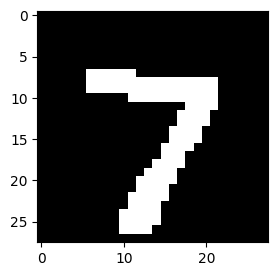

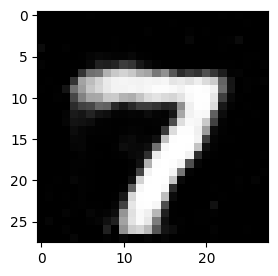

t: 182  loss : 39363.82096251893
t: 183  loss : 46016.67165070956
t: 184  loss : 44120.19334588335
t: 185  loss : 54492.11977056566
t: 186  loss : 50245.854797958265
t: 187  loss : 45335.89129857394
t: 188  loss : 35991.59586112645
t: 189  loss : 40442.48820473174
t: 190  loss : 53665.367305318614
Epoch 191
-------------------------------
t: 191  loss : 57890.021770233616
t: 192  loss : 49516.2222885831
t: 193  loss : 46472.04231833367
t: 194  loss : 49659.013358841665
t: 195  loss : 54852.272501418505
t: 196  loss : 35632.93170234318
t: 197  loss : 54049.486940509036
t: 198  loss : 54809.268113971986
t: 199  loss : 45288.055758949326
t: 200  loss : 54403.36114651048


In [45]:
demo_vae = VAE(28*28, 32)
loss = Cross_Entropy_Loss()

epochs = 200
m = train_labels.shape[0]

for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    batch_size = 60
    batch_matrix = shuffle_dataset(m, batch_size)

    l = 0.
    for batch_id in range(batch_size):
        batch_index = batch_matrix[batch_id, :]
        X = train_features[batch_index, :]
        Y = train_features[batch_index, :]

        Z = demo_vae.forward(X)
        #print(Z.shape)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_vae.backward(dL_by_dZ)

        demo_vae.update_weights(learning_rate = 0.3)

    print('t:', t+1, ' loss :', l)

    if (t % 20 == 0):
        X = test_features
        Y = demo_vae.predict(X)
        encode1 = np.resize(X[0], (28, 28))
        decode1 = np.resize(Y[0], (28, 28))

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(encode1, cmap='gray')
        plt.show()

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(decode1, cmap='gray')
        plt.show()